In [ ]:
! pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless" wandb

In [ ]:
from google.colab import drive
import os

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/rsna_data/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()

Mounted at /content/drive
Current directory: /content/drive/MyDrive/rsna_data


Notebook Color Schemes:


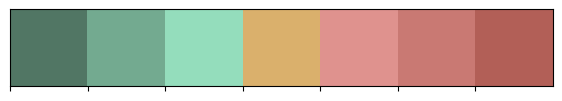

In [ ]:
# General Libraries
import os
import re
import gc
import cv2
import wandb
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'

my_colors = ["#517664", "#73AA90", "#94DDBC", "#DAB06C",
             "#DF928E", "#C97973", "#B25F57"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

!pip install -q efficientnet_pytorch
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


In [ ]:
a = pd.read_csv("train_dicom_row_data.csv")
b = pd.read_csv("train.csv")
b = b[['patient_id','extravasation_injury']]

# a의 'PatientID'와 b의 'patient_id'를 기준으로 조인
merged_df = pd.merge(a, b, left_on='PatientID', right_on='patient_id', how='inner')
merged_df.drop(columns=["patient_id"], inplace=True)
# dcm path 추가
path = 'train_images/' + merged_df['PatientID'].astype(str) + '/' + merged_df['SeriesNumber'].astype(str)
merged_df['path'] = 'train_images/' + merged_df['PatientID'].astype(str) + '/' + merged_df['SeriesNumber'].astype(str)

# 결과 출력
merged_df

,PatientID,HighBit,PatientPosition,RescaleType,SeriesNumber,aortic_hu,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,ImageOrientationPatient6,PixelSpacing1,PixelSpacing2,extravasation_injury,path
0,49954,15,0,0,41479,253.0,1.0,0.0,0.0,0.0,1.0,0.0,0.923000,0.923000,0,train_images/49954/41479
1,50737,11,1,1,59269,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.753906,0.753906,0,train_images/50737/59269
2,55903,15,1,1,29738,576.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0,train_images/55903/29738
3,55903,15,1,1,5363,246.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0,train_images/55903/5363
4,51078,15,0,1,62342,153.0,1.0,0.0,0.0,0.0,1.0,0.0,0.652344,0.652344,0,train_images/51078/62342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,14790,15,0,1,7720,282.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0,train_images/14790/7720
4707,14790,15,0,1,60494,133.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0,train_images/14790/60494
4708,9549,15,0,0,36394,245.0,1.0,0.0,0.0,0.0,1.0,0.0,0.930000,0.930000,0,train_images/9549/36394
4709,9549,15,0,0,20222,132.0,1.0,0.0,0.0,0.0,1.0,0.0,0.907000,0.907000,0,train_images/9549/20222


In [ ]:
merged_df['extravasation_injury'].value_counts()

0    4411
1     300
Name: extravasation_injury, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (Compose, Resize, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, RandomBrightnessContrast, GaussNoise, Normalize, ToFloat)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import time
# RSNADataset 클래스 정의
class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([
                # 이미지 크기 조절
                Resize(height=256, width=256),
                # 좌우 뒤집기 (수평 뒤집기) 및 상하 뒤집기 (수직 뒤집기)
                HorizontalFlip(p=self.horizontal_flip),
                VerticalFlip(p=self.vertical_flip),
                # 랜덤 회전 (90도 단위)
                RandomRotate90(p=0.5),
                # 이미지 이동, 크기 조절 및 회전
                ShiftScaleRotate(rotate_limit=20, scale_limit=0.1, p=0.5),
                # 랜덤한 밝기와 대비 조절
                # RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                # 가우시안 노이즈 추가
                # GaussNoise(p=0.2),
                # 이미지를 실수형으로 변환
                ToFloat(max_value=255.0),
                # 이미지 정규화
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # 이미지를 PyTorch 텐서로 변환
                ToTensorV2(),
            ])
        else:
            self.transform = Compose([Resize(height=256, width=256),ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        folder_path = row['path']
        file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
        image_path1 = folder_path + '/' + file_list[len(file_list)//2-1]
        image_path2 = folder_path + '/' + file_list[len(file_list)//2]
        image_path3 = folder_path + '/' + file_list[len(file_list)//2+1]
        image1 = pydicom.dcmread(image_path1).pixel_array.astype(np.float32)
        image2 = pydicom.dcmread(image_path2).pixel_array.astype(np.float32)
        image3 = pydicom.dcmread(image_path3).pixel_array.astype(np.float32)
        combined_image = np.stack([image1, image2, image3], axis=-1)

        csv_data = np.array(row[['HighBit', 'PatientPosition', 'RescaleType', 'aortic_hu', 'ImageOrientationPatient1', 'ImageOrientationPatient2', 'ImageOrientationPatient3',
                                'ImageOrientationPatient4', 'ImageOrientationPatient5', 'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2']].values, dtype=np.float32)

        transf_image = self.transform(image=combined_image)['image']

        return {"image": transf_image, "meta": csv_data, "target": row['extravasation_injury']}


# 모델 클래스 정의
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = resnet50(pretrained=True)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        self.classification = nn.Linear(1000 + 500, output_size)

    def forward(self, image, meta):
        image = self.features(image)
        meta = self.csv(meta)
        image_meta_data = torch.cat((image, meta), dim=1)
        out = self.classification(image_meta_data)
        return out

In [ ]:
vertical_flip = 0.5
horizontal_flip = 0.5
output_size = 1

# selected_df = merged_df.iloc[:100]
selected_df = merged_df

# 테스트 데이터셋 및 DataLoader 생성
negative = selected_df[selected_df['extravasation_injury'] == 0]
positive = selected_df[selected_df['extravasation_injury'] == 1]

num_samples = min(len(negative), len(positive))
negative_samples = negative.sample(n=num_samples, random_state=1234)
positive_samples = positive.sample(n=num_samples, random_state=1234)
same_num_df = pd.concat([negative_samples, positive_samples], axis=0)

train_data, valid_data = train_test_split(same_num_df, stratify=same_num_df['extravasation_injury'], test_size=0.2, shuffle=True, random_state=1234)
train_data = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
valid_data = RSNADataset(valid_data, vertical_flip, horizontal_flip,is_train=False)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)

# Device 설정 및 모델 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
no_columns = len(selected_df.columns) - 4
output_size = 1
model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# 하이퍼파라미터 설정
learning_rate = 0.005
num_epochs = 200

# Criterion 및 optimizer 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate_reduction = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, min_lr=0.00001, verbose=True)

criterion = nn.BCEWithLogitsLoss()

# 손실 기록을 저장할 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 에포크 수만큼 훈련
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # for k, data in tqdm(enumerate(itertools.islice(train_loader, 10))):
    for k, data in tqdm(enumerate(train_loader)):
        # 데이터 로드
        image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(image, meta)

        # 손실 계산
        loss = criterion(outputs.squeeze(), targets.float())

        # 역전파
        loss.backward()

        # 옵티마이저 단계
        optimizer.step()

        running_loss += loss.item() * image.size(0)

        predicted = torch.round(torch.sigmoid(outputs.squeeze()))  # 시그모이드 함수를 적용하여 예측값을 0 또는 1로 바꿉니다.
        #print(predicted)
        #print(targets)
        #print((predicted == targets).sum().item())
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    learning_rate_reduction.step(epoch_loss)

    #모델 저장
    if(epoch%50 == 49):
      checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
      }
      print("=> Saving checkpoint")
      torch.save(checkpoint, f"checkpoint/resnet50_extravasation{epoch}.pth")

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for k, data in enumerate(valid_loader):
            image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)
            outputs = model(image, meta)
            loss = criterion(outputs.squeeze(), targets.float())
            test_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            print(predicted)
            #print(targets)
            #print((predicted == targets).sum().item())
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)

    epoch_loss = test_loss / len(valid_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

15it [01:08,  4.58s/it]

Epoch 1/200, Train Loss: 4.6317, Train Accuracy: 0.5583


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 1/200, Test Loss: 2563397.6333, Test Accuracy: 0.5000


15it [01:07,  4.51s/it]

Epoch 2/200, Train Loss: 0.9563, Train Accuracy: 0.5146


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 2/200, Test Loss: 17302.3411, Test Accuracy: 0.5000


15it [01:12,  4.84s/it]

Epoch 3/200, Train Loss: 0.6981, Train Accuracy: 0.5687


tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.])
tensor([0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.])
tensor([1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 0.])
Epoch 3/200, Test Loss: 26.2132, Test Accuracy: 0.5750


15it [01:10,  4.70s/it]

Epoch 4/200, Train Loss: 0.6643, Train Accuracy: 0.5958


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 4/200, Test Loss: 2310.9445, Test Accuracy: 0.5000


15it [01:11,  4.79s/it]

Epoch 5/200, Train Loss: 0.6864, Train Accuracy: 0.5833


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 5/200, Test Loss: 529.8399, Test Accuracy: 0.5000


15it [01:09,  4.65s/it]

Epoch 6/200, Train Loss: 0.6825, Train Accuracy: 0.5833


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 6/200, Test Loss: 155.8302, Test Accuracy: 0.5000


15it [01:08,  4.57s/it]

Epoch 7/200, Train Loss: 0.6510, Train Accuracy: 0.6229


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Epoch 7/200, Test Loss: 346.3036, Test Accuracy: 0.5000


15it [01:08,  4.56s/it]

Epoch 8/200, Train Loss: 0.6734, Train Accuracy: 0.6021


tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.])
tensor([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 1.])
Epoch 8/200, Test Loss: 74.8488, Test Accuracy: 0.4167


15it [01:10,  4.71s/it]

Epoch 9/200, Train Loss: 0.6614, Train Accuracy: 0.6083


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 9/200, Test Loss: 70.6330, Test Accuracy: 0.5000


15it [01:09,  4.66s/it]

Epoch 10/200, Train Loss: 0.6828, Train Accuracy: 0.5792
Epoch 00010: reducing learning rate of group 0 to 1.5000e-03.


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 10/200, Test Loss: 398.4999, Test Accuracy: 0.5000


15it [01:09,  4.65s/it]

Epoch 11/200, Train Loss: 0.6708, Train Accuracy: 0.6104


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 11/200, Test Loss: 390.5068, Test Accuracy: 0.5000


15it [01:10,  4.72s/it]

Epoch 12/200, Train Loss: 0.6690, Train Accuracy: 0.5771


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 12/200, Test Loss: 223.8938, Test Accuracy: 0.5000


15it [01:08,  4.59s/it]

Epoch 13/200, Train Loss: 0.6542, Train Accuracy: 0.6188
Epoch 00013: reducing learning rate of group 0 to 4.5000e-04.


tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0.])
Epoch 13/200, Test Loss: 455.6653, Test Accuracy: 0.5167


15it [01:09,  4.65s/it]

Epoch 14/200, Train Loss: 0.6491, Train Accuracy: 0.6083


tensor([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0.])
Epoch 14/200, Test Loss: 352.8745, Test Accuracy: 0.4917


15it [01:09,  4.64s/it]

Epoch 15/200, Train Loss: 0.6465, Train Accuracy: 0.6021


tensor([0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.])
tensor([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0.])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 1.])
Epoch 15/200, Test Loss: 225.5968, Test Accuracy: 0.4333


15it [01:09,  4.67s/it]

Epoch 16/200, Train Loss: 0.6546, Train Accuracy: 0.6125


tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 1.])
Epoch 16/200, Test Loss: 286.4162, Test Accuracy: 0.4667


15it [01:10,  4.70s/it]

Epoch 17/200, Train Loss: 0.6361, Train Accuracy: 0.6333


tensor([0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.])
tensor([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 1.])
Epoch 17/200, Test Loss: 256.8117, Test Accuracy: 0.4417


15it [01:08,  4.59s/it]

Epoch 18/200, Train Loss: 0.6580, Train Accuracy: 0.6125


tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 1., 1., 1., 1.])
Epoch 18/200, Test Loss: 40.3118, Test Accuracy: 0.5083


15it [01:09,  4.61s/it]

Epoch 19/200, Train Loss: 0.6463, Train Accuracy: 0.6229


tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.])
tensor([1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 1.])
Epoch 19/200, Test Loss: 63.5347, Test Accuracy: 0.4083


15it [01:11,  4.73s/it]

Epoch 20/200, Train Loss: 0.6442, Train Accuracy: 0.6146
Epoch 00020: reducing learning rate of group 0 to 1.3500e-04.


tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 20/200, Test Loss: 52.2123, Test Accuracy: 0.4917


15it [01:12,  4.81s/it]

Epoch 21/200, Train Loss: 0.6451, Train Accuracy: 0.6229


tensor([0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.])
tensor([1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.])
tensor([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 1., 1.])
Epoch 21/200, Test Loss: 78.2942, Test Accuracy: 0.4167


15it [01:08,  4.56s/it]

Epoch 22/200, Train Loss: 0.6382, Train Accuracy: 0.6292


tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 22/200, Test Loss: 59.2334, Test Accuracy: 0.4917


15it [01:16,  5.10s/it]

Epoch 23/200, Train Loss: 0.6445, Train Accuracy: 0.6125
Epoch 00023: reducing learning rate of group 0 to 4.0500e-05.


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 23/200, Test Loss: 107.7693, Test Accuracy: 0.5000


15it [01:21,  5.42s/it]

Epoch 24/200, Train Loss: 0.6419, Train Accuracy: 0.6188


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 24/200, Test Loss: 127.4322, Test Accuracy: 0.5000


15it [01:22,  5.49s/it]

Epoch 25/200, Train Loss: 0.6391, Train Accuracy: 0.6396


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 25/200, Test Loss: 130.8427, Test Accuracy: 0.5000


15it [01:21,  5.45s/it]

Epoch 26/200, Train Loss: 0.6417, Train Accuracy: 0.6229
Epoch 00026: reducing learning rate of group 0 to 1.2150e-05.


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 26/200, Test Loss: 161.2491, Test Accuracy: 0.5000


15it [01:23,  5.58s/it]

Epoch 27/200, Train Loss: 0.6438, Train Accuracy: 0.6312


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 27/200, Test Loss: 167.3105, Test Accuracy: 0.5000


15it [01:21,  5.44s/it]

Epoch 28/200, Train Loss: 0.6471, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 28/200, Test Loss: 165.1236, Test Accuracy: 0.5000


15it [01:23,  5.55s/it]

Epoch 29/200, Train Loss: 0.6458, Train Accuracy: 0.6292
Epoch 00029: reducing learning rate of group 0 to 1.0000e-05.


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 29/200, Test Loss: 166.2624, Test Accuracy: 0.5000


15it [01:21,  5.46s/it]

Epoch 30/200, Train Loss: 0.6394, Train Accuracy: 0.6354


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 30/200, Test Loss: 150.1119, Test Accuracy: 0.5000


15it [01:13,  4.89s/it]

Epoch 31/200, Train Loss: 0.6365, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 31/200, Test Loss: 149.6481, Test Accuracy: 0.5000


15it [01:15,  5.06s/it]

Epoch 32/200, Train Loss: 0.6365, Train Accuracy: 0.6208


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 32/200, Test Loss: 155.0302, Test Accuracy: 0.5000


15it [01:25,  5.71s/it]

Epoch 33/200, Train Loss: 0.6436, Train Accuracy: 0.6167


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 33/200, Test Loss: 153.0886, Test Accuracy: 0.5000


15it [01:09,  4.63s/it]

Epoch 34/200, Train Loss: 0.6454, Train Accuracy: 0.6312


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 34/200, Test Loss: 146.3739, Test Accuracy: 0.5000


15it [01:10,  4.69s/it]

Epoch 35/200, Train Loss: 0.6495, Train Accuracy: 0.6208


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 35/200, Test Loss: 139.9246, Test Accuracy: 0.5000


15it [01:08,  4.58s/it]

Epoch 36/200, Train Loss: 0.6568, Train Accuracy: 0.6188


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 36/200, Test Loss: 133.3284, Test Accuracy: 0.5000


15it [01:10,  4.72s/it]

Epoch 37/200, Train Loss: 0.6322, Train Accuracy: 0.6479


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 37/200, Test Loss: 139.1700, Test Accuracy: 0.5000


15it [01:10,  4.68s/it]

Epoch 38/200, Train Loss: 0.6383, Train Accuracy: 0.6375


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 38/200, Test Loss: 137.2956, Test Accuracy: 0.5000


15it [01:12,  4.80s/it]

Epoch 39/200, Train Loss: 0.6472, Train Accuracy: 0.6333


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 39/200, Test Loss: 149.3298, Test Accuracy: 0.5000


15it [01:10,  4.68s/it]

Epoch 40/200, Train Loss: 0.6478, Train Accuracy: 0.6250


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 40/200, Test Loss: 142.2910, Test Accuracy: 0.5000


15it [01:09,  4.64s/it]

Epoch 41/200, Train Loss: 0.6397, Train Accuracy: 0.6438


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 41/200, Test Loss: 139.6551, Test Accuracy: 0.5000


15it [01:09,  4.66s/it]

Epoch 42/200, Train Loss: 0.6447, Train Accuracy: 0.6354


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 42/200, Test Loss: 129.3419, Test Accuracy: 0.5000


15it [01:09,  4.66s/it]

Epoch 43/200, Train Loss: 0.6470, Train Accuracy: 0.6146


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 43/200, Test Loss: 130.5006, Test Accuracy: 0.5000


15it [01:10,  4.70s/it]

Epoch 44/200, Train Loss: 0.6385, Train Accuracy: 0.6333


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 44/200, Test Loss: 140.8267, Test Accuracy: 0.5000


15it [01:08,  4.58s/it]

Epoch 45/200, Train Loss: 0.6361, Train Accuracy: 0.6229


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 45/200, Test Loss: 147.7078, Test Accuracy: 0.5000


15it [01:09,  4.66s/it]

Epoch 46/200, Train Loss: 0.6443, Train Accuracy: 0.6188


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 46/200, Test Loss: 140.8499, Test Accuracy: 0.5000


15it [01:10,  4.71s/it]

Epoch 47/200, Train Loss: 0.6426, Train Accuracy: 0.6188


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 47/200, Test Loss: 143.9807, Test Accuracy: 0.5000


15it [01:08,  4.59s/it]

Epoch 48/200, Train Loss: 0.6355, Train Accuracy: 0.6375


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 48/200, Test Loss: 151.8304, Test Accuracy: 0.5000


15it [01:09,  4.60s/it]

Epoch 49/200, Train Loss: 0.6355, Train Accuracy: 0.6229


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 49/200, Test Loss: 145.8639, Test Accuracy: 0.5000


15it [01:10,  4.69s/it]


Epoch 50/200, Train Loss: 0.6389, Train Accuracy: 0.6188
=> Saving checkpoint
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 50/200, Test Loss: 152.7160, Test Accuracy: 0.5000


15it [01:11,  4.75s/it]

Epoch 51/200, Train Loss: 0.6434, Train Accuracy: 0.6167


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 51/200, Test Loss: 158.1109, Test Accuracy: 0.5000


15it [01:10,  4.68s/it]

Epoch 52/200, Train Loss: 0.6348, Train Accuracy: 0.6188


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 52/200, Test Loss: 158.5071, Test Accuracy: 0.5000


15it [01:10,  4.73s/it]

Epoch 53/200, Train Loss: 0.6424, Train Accuracy: 0.6125


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 53/200, Test Loss: 155.6880, Test Accuracy: 0.5000


15it [01:11,  4.75s/it]

Epoch 54/200, Train Loss: 0.6475, Train Accuracy: 0.6250


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 54/200, Test Loss: 164.4062, Test Accuracy: 0.5000


15it [01:08,  4.55s/it]

Epoch 55/200, Train Loss: 0.6356, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 55/200, Test Loss: 182.6622, Test Accuracy: 0.5000


15it [01:08,  4.60s/it]

Epoch 56/200, Train Loss: 0.6545, Train Accuracy: 0.6146


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 56/200, Test Loss: 180.6615, Test Accuracy: 0.5000


15it [01:09,  4.65s/it]

Epoch 57/200, Train Loss: 0.6428, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 57/200, Test Loss: 181.2673, Test Accuracy: 0.5000


15it [01:09,  4.65s/it]

Epoch 58/200, Train Loss: 0.6492, Train Accuracy: 0.6188


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 58/200, Test Loss: 189.5045, Test Accuracy: 0.5000


15it [01:09,  4.65s/it]

Epoch 59/200, Train Loss: 0.6422, Train Accuracy: 0.6271


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 59/200, Test Loss: 176.4227, Test Accuracy: 0.5000


15it [01:10,  4.71s/it]

Epoch 60/200, Train Loss: 0.6458, Train Accuracy: 0.6083


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 60/200, Test Loss: 170.0193, Test Accuracy: 0.5000


15it [01:11,  4.75s/it]

Epoch 61/200, Train Loss: 0.6485, Train Accuracy: 0.6208


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 61/200, Test Loss: 179.2886, Test Accuracy: 0.5000


15it [01:08,  4.60s/it]

Epoch 62/200, Train Loss: 0.6360, Train Accuracy: 0.6375


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 62/200, Test Loss: 183.6365, Test Accuracy: 0.5000


15it [01:08,  4.56s/it]

Epoch 63/200, Train Loss: 0.6463, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 63/200, Test Loss: 172.1214, Test Accuracy: 0.5000


15it [01:08,  4.56s/it]

Epoch 64/200, Train Loss: 0.6387, Train Accuracy: 0.6271


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 64/200, Test Loss: 168.7942, Test Accuracy: 0.5000


15it [01:09,  4.66s/it]

Epoch 65/200, Train Loss: 0.6422, Train Accuracy: 0.6250


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 65/200, Test Loss: 180.3641, Test Accuracy: 0.5000


15it [01:09,  4.66s/it]

Epoch 66/200, Train Loss: 0.6455, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 66/200, Test Loss: 176.7803, Test Accuracy: 0.5000


15it [01:08,  4.54s/it]

Epoch 67/200, Train Loss: 0.6381, Train Accuracy: 0.6271


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 67/200, Test Loss: 171.6808, Test Accuracy: 0.5000


15it [01:09,  4.66s/it]

Epoch 68/200, Train Loss: 0.6430, Train Accuracy: 0.6188


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 68/200, Test Loss: 176.6986, Test Accuracy: 0.5000


15it [01:09,  4.64s/it]

Epoch 69/200, Train Loss: 0.6431, Train Accuracy: 0.6250


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 69/200, Test Loss: 173.8711, Test Accuracy: 0.5000


15it [01:09,  4.65s/it]

Epoch 70/200, Train Loss: 0.6415, Train Accuracy: 0.6229


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 70/200, Test Loss: 177.2212, Test Accuracy: 0.5000


15it [01:11,  4.74s/it]

Epoch 71/200, Train Loss: 0.6427, Train Accuracy: 0.6271


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 71/200, Test Loss: 172.2951, Test Accuracy: 0.5000


15it [01:09,  4.61s/it]

Epoch 72/200, Train Loss: 0.6407, Train Accuracy: 0.6312


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 72/200, Test Loss: 157.0388, Test Accuracy: 0.5000


15it [01:09,  4.66s/it]

Epoch 73/200, Train Loss: 0.6379, Train Accuracy: 0.6208


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 73/200, Test Loss: 154.6129, Test Accuracy: 0.5000


15it [01:09,  4.60s/it]

Epoch 74/200, Train Loss: 0.6380, Train Accuracy: 0.6500


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 74/200, Test Loss: 166.6957, Test Accuracy: 0.5000


15it [01:08,  4.60s/it]

Epoch 75/200, Train Loss: 0.6404, Train Accuracy: 0.6250


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 75/200, Test Loss: 167.4184, Test Accuracy: 0.5000


15it [01:09,  4.63s/it]

Epoch 76/200, Train Loss: 0.6380, Train Accuracy: 0.6167


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 76/200, Test Loss: 190.6210, Test Accuracy: 0.5000


15it [01:09,  4.65s/it]

Epoch 77/200, Train Loss: 0.6467, Train Accuracy: 0.6250


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 77/200, Test Loss: 185.9584, Test Accuracy: 0.5000


15it [01:08,  4.60s/it]

Epoch 78/200, Train Loss: 0.6377, Train Accuracy: 0.6333


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 78/200, Test Loss: 170.7544, Test Accuracy: 0.5000


15it [01:08,  4.58s/it]

Epoch 79/200, Train Loss: 0.6443, Train Accuracy: 0.6271


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 79/200, Test Loss: 164.8532, Test Accuracy: 0.5000


15it [01:07,  4.51s/it]

Epoch 80/200, Train Loss: 0.6427, Train Accuracy: 0.6146


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 80/200, Test Loss: 168.9112, Test Accuracy: 0.5000


15it [01:08,  4.57s/it]

Epoch 81/200, Train Loss: 0.6394, Train Accuracy: 0.6271


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 81/200, Test Loss: 163.0305, Test Accuracy: 0.5000


15it [01:08,  4.59s/it]

Epoch 82/200, Train Loss: 0.6414, Train Accuracy: 0.6354


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 82/200, Test Loss: 162.6820, Test Accuracy: 0.5000


15it [01:10,  4.70s/it]

Epoch 83/200, Train Loss: 0.6437, Train Accuracy: 0.6167


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 83/200, Test Loss: 158.0039, Test Accuracy: 0.5000


15it [01:08,  4.59s/it]

Epoch 84/200, Train Loss: 0.6359, Train Accuracy: 0.6312


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 84/200, Test Loss: 159.9715, Test Accuracy: 0.5000


15it [01:11,  4.74s/it]

Epoch 85/200, Train Loss: 0.6399, Train Accuracy: 0.6354


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 85/200, Test Loss: 134.2087, Test Accuracy: 0.5000


15it [01:12,  4.86s/it]

Epoch 86/200, Train Loss: 0.6410, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 86/200, Test Loss: 146.4584, Test Accuracy: 0.5000


15it [01:10,  4.71s/it]

Epoch 87/200, Train Loss: 0.6440, Train Accuracy: 0.6333


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 87/200, Test Loss: 159.4268, Test Accuracy: 0.5000


15it [01:07,  4.53s/it]

Epoch 88/200, Train Loss: 0.6510, Train Accuracy: 0.6375


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 88/200, Test Loss: 155.0870, Test Accuracy: 0.5000


15it [01:08,  4.57s/it]

Epoch 89/200, Train Loss: 0.6429, Train Accuracy: 0.6167


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 89/200, Test Loss: 152.6746, Test Accuracy: 0.5000


15it [01:07,  4.48s/it]

Epoch 90/200, Train Loss: 0.6352, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 90/200, Test Loss: 161.3327, Test Accuracy: 0.5000


15it [01:08,  4.56s/it]

Epoch 91/200, Train Loss: 0.6468, Train Accuracy: 0.6375


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 91/200, Test Loss: 147.7729, Test Accuracy: 0.5000


15it [01:08,  4.58s/it]

Epoch 92/200, Train Loss: 0.6325, Train Accuracy: 0.6312


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 92/200, Test Loss: 150.9380, Test Accuracy: 0.5000


15it [01:06,  4.45s/it]

Epoch 93/200, Train Loss: 0.6469, Train Accuracy: 0.6229


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 93/200, Test Loss: 147.5438, Test Accuracy: 0.5000


15it [01:08,  4.59s/it]

Epoch 94/200, Train Loss: 0.6518, Train Accuracy: 0.6229


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 94/200, Test Loss: 158.3368, Test Accuracy: 0.5000


15it [01:08,  4.53s/it]

Epoch 95/200, Train Loss: 0.6481, Train Accuracy: 0.6125


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 95/200, Test Loss: 170.4083, Test Accuracy: 0.5000


15it [01:07,  4.53s/it]

Epoch 96/200, Train Loss: 0.6435, Train Accuracy: 0.6292


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 96/200, Test Loss: 159.9521, Test Accuracy: 0.5000


15it [01:08,  4.54s/it]

Epoch 97/200, Train Loss: 0.6468, Train Accuracy: 0.6167


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 97/200, Test Loss: 166.7142, Test Accuracy: 0.5000


15it [01:07,  4.53s/it]

Epoch 98/200, Train Loss: 0.6413, Train Accuracy: 0.6146


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 98/200, Test Loss: 158.2208, Test Accuracy: 0.5000


15it [01:08,  4.58s/it]

Epoch 99/200, Train Loss: 0.6463, Train Accuracy: 0.6375


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 99/200, Test Loss: 157.8868, Test Accuracy: 0.5000


15it [01:06,  4.46s/it]


Epoch 100/200, Train Loss: 0.6380, Train Accuracy: 0.6354
=> Saving checkpoint
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 100/200, Test Loss: 159.1141, Test Accuracy: 0.5000


15it [01:08,  4.57s/it]

Epoch 101/200, Train Loss: 0.6371, Train Accuracy: 0.6229


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 101/200, Test Loss: 176.4270, Test Accuracy: 0.5000


15it [01:07,  4.50s/it]

Epoch 102/200, Train Loss: 0.6319, Train Accuracy: 0.6375


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 102/200, Test Loss: 152.2959, Test Accuracy: 0.5000


15it [01:09,  4.65s/it]

Epoch 103/200, Train Loss: 0.6510, Train Accuracy: 0.6021


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 103/200, Test Loss: 157.5244, Test Accuracy: 0.5000


15it [01:09,  4.61s/it]

Epoch 104/200, Train Loss: 0.6338, Train Accuracy: 0.6354


tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])
Epoch 104/200, Test Loss: 143.1322, Test Accuracy: 0.5000


9it [00:46,  5.16s/it]


KeyboardInterrupt: ignored

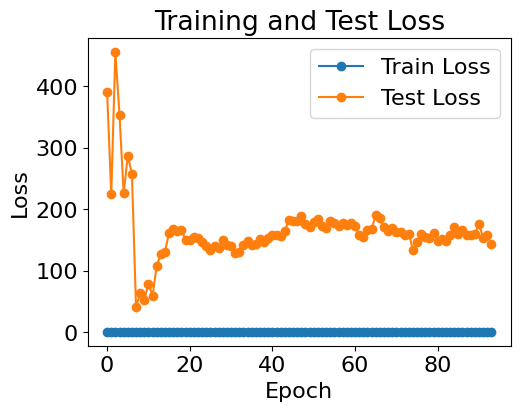

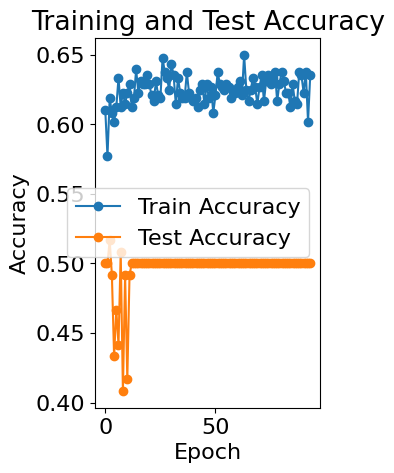

In [ ]:
# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_losses[10:], '-o', label='Train Loss')
plt.plot(test_losses[10:], '-o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies[10:], '-o', label='Train Accuracy')
plt.plot(test_accuracies[10:], '-o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

In [ ]:
a = pd.read_csv("train_series_meta.csv")
a = a[['patient_id','series_id']]
b = pd.read_csv("train.csv")
b = b[['patient_id','extravasation_injury']]

# a의 'PatientID'와 b의 'patient_id'를 기준으로 조인
merged_df = pd.merge(a, b, on='patient_id', how='inner')

# dcm path 추가
path = 'train_images/' + merged_df['patient_id'].astype(str) + '/' + merged_df['series_id'].astype(str)
merged_df['path'] = 'train_images/' + merged_df['patient_id'].astype(str) + '/' + merged_df['series_id'].astype(str)

# 결과 출력
merged_df

,patient_id,series_id,extravasation_injury,path
0,10004,21057,1,train_images/10004/21057
1,10004,51033,1,train_images/10004/51033
2,10005,18667,0,train_images/10005/18667
3,10007,47578,0,train_images/10007/47578
4,10026,29700,0,train_images/10026/29700
...,...,...,...,...
4706,9961,2003,0,train_images/9961/2003
4707,9961,63032,0,train_images/9961/63032
4708,9980,40214,0,train_images/9980/40214
4709,9980,40466,0,train_images/9980/40466


In [ ]:
merged_df['extravasation_injury'].value_counts()

0    4411
1     300
Name: extravasation_injury, dtype: int64

In [ ]:
!pip install timm

In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (Compose, Resize, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, RandomBrightnessContrast, GaussNoise, Normalize, ToFloat)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import timm

# RSNADataset 클래스 정의
class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([
                # 이미지 크기 조절
                Resize(height=456, width=456),
                # 좌우 뒤집기 (수평 뒤집기) 및 상하 뒤집기 (수직 뒤집기)
                HorizontalFlip(p=self.horizontal_flip),
                VerticalFlip(p=self.vertical_flip),
                # 랜덤 회전 (90도 단위)
                RandomRotate90(p=0.5),
                # 이미지 이동, 크기 조절 및 회전
                ShiftScaleRotate(rotate_limit=20, scale_limit=0.1, p=0.5),
                # 랜덤한 밝기와 대비 조절
                RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                # 가우시안 노이즈 추가
                GaussNoise(p=0.2),
                # 이미지를 실수형으로 변환
                ToFloat(max_value=255.0),
                # 이미지 정규화
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # 이미지를 PyTorch 텐서로 변환
                ToTensorV2(),
            ])
        else:
            self.transform = Compose([Resize(height=456, width=456), ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        folder_path = row['path']
        file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
        image_path1 = folder_path + '/' + file_list[len(file_list)//2-1]
        image_path2 = folder_path + '/' + file_list[len(file_list)//2]
        image_path3 = folder_path + '/' + file_list[len(file_list)//2+1]
        image1 = pydicom.dcmread(image_path1).pixel_array.astype(np.float32)
        image2 = pydicom.dcmread(image_path2).pixel_array.astype(np.float32)
        image3 = pydicom.dcmread(image_path3).pixel_array.astype(np.float32)
        combined_image = np.stack([image1, image2, image3], axis=-1)

        transf_image = self.transform(image=combined_image)['image']

        return {"image": transf_image, "target": row['extravasation_injury']}

class EfficientNetNetwork(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = timm.create_model('efficientnet_b5', pretrained=True)
        self.classification = nn.Linear(1000, output_size)  # efficientnet_b0의 feature 크기는 1280

    def forward(self, image):
        image = self.features(image)
        out = self.classification(image)
        return out

In [ ]:
vertical_flip = 0.5
horizontal_flip = 0.5
output_size = 1

# selected_df = merged_df.iloc[:100]
selected_df = merged_df

# 테스트 데이터셋 및 DataLoader 생성
negative = selected_df[selected_df['extravasation_injury'] == 0]
positive = selected_df[selected_df['extravasation_injury'] == 1]

num_samples = min(len(negative), len(positive))
negative_samples = negative.sample(n=num_samples, random_state=1234)
positive_samples = positive.sample(n=num_samples, random_state=1234)
same_num_df = pd.concat([negative_samples, positive_samples], axis=0)

train_data, valid_data = train_test_split(same_num_df, stratify=same_num_df['extravasation_injury'], test_size=0.2, shuffle=True, random_state=1234)
train_data = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
valid_data = RSNADataset(valid_data, vertical_flip, horizontal_flip,is_train=False)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=False, num_workers=2)

# Device 설정 및 모델 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_size = 1
model = EfficientNetNetwork(output_size=output_size).to(DEVICE)
#model.load_state_dict(torch.load("checkpoint/EfficientB3_extravasation99.pth", map_location=DEVICE)["state_dict"])

# 하이퍼파라미터 설정
learning_rate = 0.005
num_epochs = 200

# Criterion 및 optimizer 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate_reduction = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, min_lr=0.00001, verbose=True)

criterion = nn.BCEWithLogitsLoss()

# 손실 기록을 저장할 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 에포크 수만큼 훈련
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # for k, data in tqdm(enumerate(itertools.islice(train_loader, 10))):
    for k, data in tqdm(enumerate(train_loader)):
        # 데이터 로드
        image, targets = data['image'].to(DEVICE), data['target'].to(DEVICE)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(image)

        # 손실 계산
        loss = criterion(outputs.squeeze(), targets.float())

        # 역전파
        loss.backward()

        # 옵티마이저 단계
        optimizer.step()

        running_loss += loss.item() * image.size(0)

        predicted = torch.round(torch.sigmoid(outputs.squeeze()))  # 시그모이드 함수를 적용하여 예측값을 0 또는 1로 바꿉니다.
        #print(predicted)
        #print(targets)
        #print((predicted == targets).sum().item())
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    learning_rate_reduction.step(epoch_loss)

    #모델 저장
    if(epoch%20 == 19):
      checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
      }
      print("=> Saving checkpoint")
      torch.save(checkpoint, f"checkpoint/EfficientB5_extravasation{epoch}.pth")

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for k, data in enumerate(valid_loader):
            image, targets = data['image'].to(DEVICE), data['target'].to(DEVICE)
            outputs = model(image)
            loss = criterion(outputs.squeeze(), targets.float())
            test_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            print(predicted)
            #print(targets)
            #print((predicted == targets).sum().item())
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)

    epoch_loss = test_loss / len(valid_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

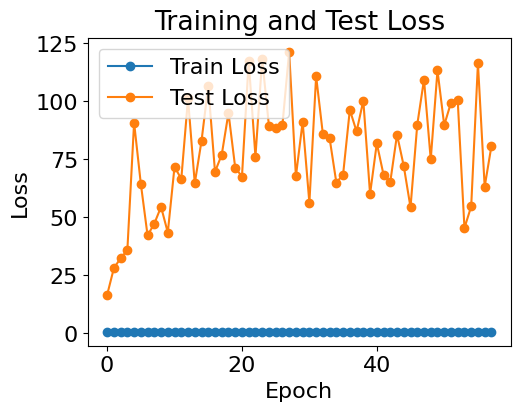

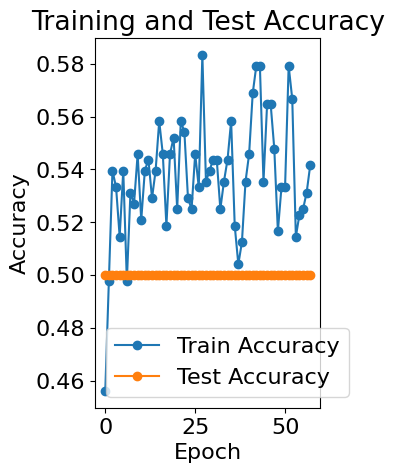

In [ ]:
# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_losses[10:], '-o', label='Train Loss')
plt.plot(test_losses[10:], '-o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies[10:], '-o', label='Train Accuracy')
plt.plot(test_accuracies[10:], '-o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()